# CHASV_60model.v3.3.1, train threshold and new subgroup, age ~70
split 7:3

In [1]:
SEED = 0
cores = 16

from numpy.random import seed
seed(SEED)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from xgboost import plot_importance
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import joblib
from BorutaShap import BorutaShap
import tqdm

# version check
import sys
print("python version")
print(sys.version)
import sklearn
print("sklearn version = ", sklearn.__version__)
print("numpy version = ", np.__version__)
print("pandas version =", pd.__version__)

python version
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sklearn version =  0.23.2
numpy version =  1.19.2
pandas version = 1.2.3


In [3]:
df = pd.read_csv("/home/danssa/proj_ua/data/chasv_development.v2.csv", dtype={'id':np.str})
df_age1 = df.query('age<70')
df_age2 = df.query('age<75')

df2 = df_age1.loc[df['from']!="knhanes"]
df2.describe()

,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,dm,htn
count,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000,197263.000000
mean,0.036180,96.849245,0.427855,43.820858,6.196740,0.015426,1.018770,0.307240,0.207591,0.211768,0.038684,0.738613,0.161885,0.491881,0.025063,0.039080
std,0.186739,20.055817,0.494769,12.589140,0.819202,0.123240,0.007983,0.739573,0.842624,0.684205,0.320413,1.248134,0.550740,0.997794,0.156317,0.193785
min,0.000000,1.704754,0.000000,18.000000,5.000000,0.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,84.281460,0.000000,34.000000,5.500000,0.000000,1.015000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,98.451770,0.000000,43.000000,6.000000,0.000000,1.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,111.824100,1.000000,54.000000,7.000000,0.000000,1.025000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,257.176000,1.000000,69.000000,9.000000,1.000000,1.030000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000


## train and test set : multi staratification (eGFR and age)

In [4]:
#3group age split  

##step 1 finding edge value
abnormal_disc = df2.query('eGFR_ab==1').loc[:,'age']
abnormal_disc = pd.DataFrame(abnormal_disc)

est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
est.fit(abnormal_disc)

ab_disc = est.transform(abnormal_disc).astype('float')
print("edges : ", est.bin_edges_[0])

age0_edge = est.bin_edges_[0][1]
age1_edge = est.bin_edges_[0][2]
age2_edge = est.bin_edges_[0][3]
print('age0_edge:', age0_edge, '\nage1_edge:', age1_edge, '\nage2_edge:', age2_edge)

abnormal_disc['level'] = abnormal_disc.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print('age group:\n',abnormal_disc['level'].value_counts().sort_index())

edges :  [18.         43.55887666 57.931673   69.        ]
age0_edge: 43.55887666024966 
age1_edge: 57.93167299739484 
age2_edge: 69.0
age group:
 0     805
1    2052
2    4280
Name: level, dtype: int64


In [5]:
##make 3group by age
df3 = df2.copy()

##age cut set up
df3['level'] = df3.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print(df3['level'].value_counts())

0    103374
1     58530
2     35359
Name: level, dtype: int64


In [6]:
##age0 group
X_age0 = df3[df3['level']==0]
y_age0 = X_age0['eGFR_ab'].astype("int64")

print('\nage0', X_age0['age'].min(), X_age0['age'].max())
print("total cases = %d" %X_age0.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age0), "\nprevalence =", sum(y_age0)/len(y_age0)*100)

X_train0, X_test0, y_train0, y_test0 = train_test_split(X_age0, y_age0, test_size=0.3, stratify=y_age0, random_state=SEED)
print("train0 : %d" % sum(y_train0), "test0 : %d" % sum(y_test0))

##age1 group
X_age1 = df3[df3['level']==1]
y_age1 = X_age1['eGFR_ab']

print('\nage1', X_age1['age'].min(), X_age1['age'].max())
print("total cases = %d" %X_age1.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age1), "\nprevalence =", sum(y_age1)/len(y_age1)*100)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_age1, y_age1, test_size=0.3, stratify=y_age1, random_state=SEED)
print("train1 : %d" % sum(y_train1), "test1 : %d" % sum(y_test1))

##age2 group
X_age2 = df3[df3['level']==2]
y_age2 = X_age2['eGFR_ab']

print('\nage2', X_age2['age'].min(), X_age2['age'].max())
print("total cases = %d" %X_age2.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age2), "\nprevalence =", sum(y_age2)/len(y_age2)*100)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_age2, y_age2, test_size=0.3, stratify=y_age2, random_state=SEED)
print("train2 : %d" % sum(y_train2), "test2 : %d" % sum(y_test2))


age0 18 43
total cases = 103374
total abnormal function of kidney = 805 
prevalence = 0.7787257917851684
train0 : 563 test0 : 242

age1 44 57
total cases = 58530
total abnormal function of kidney = 2052 
prevalence = 3.505894413121476
train1 : 1436 test1 : 616

age2 58 69
total cases = 35359
total abnormal function of kidney = 4280 
prevalence = 12.104414717610792
train2 : 2996 test2 : 1284


In [7]:
##concat both trainset and testset
X_train = pd.concat([X_train0, X_train1, X_train2])
y_train = pd.concat([y_train0, y_train1, y_train2])

X_test = pd.concat([X_test0, X_test1, X_test2])
y_test = pd.concat([y_test0, y_test1, y_test2])

print("total cases = %d" % (X_train.shape[0] + X_test.shape[0]))
print("total abnormal function of kidney = %d" % (sum(y_train) + sum(y_test)), "\nprevalence =", (sum(y_train)+sum(y_test))/(len(y_train)+len(y_test))*100)

total cases = 197263
total abnormal function of kidney = 7137 
prevalence = 3.6180125010772417


## model features and standardization

In [8]:
X_train_features = X_train.loc[:, 'male':'leucocyte']

print('%d train cases, %d variables' % (X_train_features.shape[0], X_train_features.shape[1]))
print('%d test cases'%X_test.shape[0])

138083 train cases, 12 variables
59180 test cases


In [9]:
#standardization

scaler = StandardScaler()
std_cols=['age','he_uph','he_usg']
std_df=X_train_features[std_cols]

X_train_features[std_cols]=scaler.fit_transform(std_df)
X_train_features.describe()

,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte
count,138083.000000,1.380830e+05,1.380830e+05,138083.000000,1.380830e+05,138083.000000,138083.000000,138083.000000,138083.000000,138083.000000,138083.000000,138083.000000
mean,0.427685,-1.317316e-17,4.874069e-16,0.015426,-1.038374e-14,0.305867,0.206571,0.211054,0.039042,0.737542,0.160867,0.490734
std,0.494745,1.000004e+00,1.000004e+00,0.123238,1.000004e+00,0.738457,0.839936,0.682632,0.321861,1.247623,0.550539,0.998336
min,0.000000,-2.049442e+00,-1.463852e+00,0.000000,-1.724754e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-7.792453e-01,-8.526849e-01,0.000000,-4.723721e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-6.475950e-02,-2.415181e-01,0.000000,1.538189e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,8.085009e-01,9.808156e-01,0.000000,7.800099e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.999311e+00,3.425483e+00,1.000000,1.406201e+00,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000


## initial model and final model fit

In [10]:
#model fit and mean accuracy
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=8, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=cores)
    return scores

#model : chasv_60model.v2
model = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=2.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=500, 
                        objective="binary:logistic", reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=0.2,
                        nthread=6, random_state=SEED).fit(X_train_features, y_train)
scores = evaluate_model(X_train_features, y_train, model)
print('Mean AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean AUC: 0.900 (0.004)


In [11]:
# dimensionality reduction using feature importance
df_imp = pd.DataFrame({'imp':model.feature_importances_}, index = model.get_booster().feature_names)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()

feat_num = df_imp.shape[0]
print("total number of features =", feat_num)
df_imp

total number of features = 12


,imp
he_unitr,0.018479
leucocyte,0.023913
he_uket,0.026169
he_ubil,0.027990
he_uro,0.028652
male,0.053689
he_usg,0.063544
he_uph,0.068571
he_ubld,0.071065
he_uglu,0.076565


In [12]:
# new model 

## new trainset
X_train_features_new = X_train_features.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]

## model: chasv_60model.v1
model_new = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=2.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=500, 
                        objective="binary:logistic", reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=0.2,
                           nthread=6, random_state=SEED).fit(X_train_features_new, y_train)
scores_new = evaluate_model(X_train_features_new, y_train, model_new)
print('Mean AUC of new model : %.3f (%.3f)' % (mean(scores_new), std(scores_new)))

Mean AUC of new model : 0.900 (0.004)


## find out threshold all and subgroups in train set

In [13]:
df_train = X_train.copy()
df_train['prob'] = model_new.predict_proba(X_train_features_new)[:,1]

train_all = df_train.copy()
train_sub1 = df_train.query('dm==1')
train_sub2 = df_train.query('htn==1')
train_sub3 = df_train.query('age<65')
train_sub4 = df_train.query('age>=65')

In [14]:
print('train set')
print('total cases, prevalence (cases)')
print('train all: %d, %.1f (%d)' % (len(train_all), sum(train_all['eGFR_ab'])/len(train_all)*100, sum(train_all['eGFR_ab'])))
print('subgroup1: %d, %.1f (%d)' % (len(train_sub1), sum(train_sub1['eGFR_ab'])/len(train_sub1)*100, sum(train_sub1['eGFR_ab'])))
print('subgroup2: %d, %.1f (%d)' % (len(train_sub2), sum(train_sub2['eGFR_ab'])/len(train_sub2)*100, sum(train_sub2['eGFR_ab'])))
print('subgroup3: %d, %.1f (%d)' % (len(train_sub3), sum(train_sub3['eGFR_ab'])/len(train_sub3)*100, sum(train_sub3['eGFR_ab'])))
print('subgroup4: %d, %.1f (%d)' % (len(train_sub4), sum(train_sub4['eGFR_ab'])/len(train_sub4)*100, sum(train_sub4['eGFR_ab'])))

train set
total cases, prevalence (cases)
train all: 138083, 3.6 (4995)
subgroup1: 3446, 3.2 (111)
subgroup2: 5396, 1.6 (88)
subgroup3: 129112, 2.6 (3418)
subgroup4: 8971, 17.6 (1577)


In [15]:
# confidence intervals
def cical(box, alpha=0.95):
    p = ((1.0-alpha)/2.0)*100
    lower = max(0.0, np.percentile(box, p))
    p = (alpha+((1.0-alpha)/2.0))*100
    upper = min(1.0, np.percentile(box, p))
   # mean = mean(box)
    median = np.median(box)
    
    return print('mean(ci): %.2f (%.2f-%.2f), median:%.2f' % (mean(box), lower, upper, np.median(box)))

### train_all

In [16]:
# configure bootstrap
data = train_all

n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_train_all = []
th_box_train_all = []
se_box_train_all = []
sp_box_train_all = []

# for loop
with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
        
        auc_box_train_all.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_train_all.append(best_thresh)
        se_box_train_all.append(se)
        sp_box_train_all.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [16:49<00:00,  9.91it/s]


In [17]:
print('train_all, bootstrap\nauc-se-sp-th')
cical(auc_box_train_all)
cical(se_box_train_all)
cical(sp_box_train_all)
cical(th_box_train_all)

train_all, bootstrap
auc-se-sp-th
mean(ci): 0.90 (0.90-0.91), median:0.90
mean(ci): 0.84 (0.82-0.86), median:0.84
mean(ci): 0.80 (0.79-0.82), median:0.80
mean(ci): 0.34 (0.32-0.37), median:0.33


### train_sub1, diabetes

In [18]:
# configure bootstrap
data = train_sub1

n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_train_sub1 = []
th_box_train_sub1 = []
se_box_train_sub1 = []
sp_box_train_sub1 = []

# for loop
with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
        
        auc_box_train_sub1.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_train_sub1.append(best_thresh)
        se_box_train_sub1.append(se)
        sp_box_train_sub1.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [00:37<00:00, 266.09it/s]


In [19]:
print('train_sub1, bootstrap\nauc-se-sp-th')
cical(auc_box_train_sub1)
cical(se_box_train_sub1)
cical(sp_box_train_sub1)
cical(th_box_train_sub1)

train_sub1, bootstrap
auc-se-sp-th
mean(ci): 0.86 (0.82-0.90), median:0.86
mean(ci): 0.74 (0.63-0.84), median:0.74
mean(ci): 0.87 (0.78-0.93), median:0.88
mean(ci): 0.58 (0.47-0.66), median:0.59


### train_sub2, hypertension

In [20]:
# configure bootstrap
data = train_sub2

n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_train_sub2 = []
th_box_train_sub2 = []
se_box_train_sub2 = []
sp_box_train_sub2 = []

# for loop
with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
        
        auc_box_train_sub2.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_train_sub2.append(best_thresh)
        se_box_train_sub2.append(se)
        sp_box_train_sub2.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [00:48<00:00, 207.08it/s]


In [21]:
print('train_sub2, bootstrap\nauc-se-sp-th')
cical(auc_box_train_sub2)
cical(se_box_train_sub2)
cical(sp_box_train_sub2)
cical(th_box_train_sub2)

train_sub2, bootstrap
auc-se-sp-th
mean(ci): 0.85 (0.81-0.89), median:0.85
mean(ci): 0.77 (0.62-0.92), median:0.76
mean(ci): 0.79 (0.64-0.90), median:0.80
mean(ci): 0.45 (0.27-0.57), median:0.44


### train_sub3, age<65

In [22]:
# configure bootstrap
data = train_sub3

n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_train_sub3 = []
th_box_train_sub3 = []
se_box_train_sub3 = []
sp_box_train_sub3 = []

# for loop
with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
        
        auc_box_train_sub3.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_train_sub3.append(best_thresh)
        se_box_train_sub3.append(se)
        sp_box_train_sub3.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [15:48<00:00, 10.55it/s]


In [23]:
print('train_sub3, bootstrap\nauc-se-sp-th')
cical(auc_box_train_sub3)
cical(se_box_train_sub3)
cical(sp_box_train_sub3)
cical(th_box_train_sub3)

train_sub3, bootstrap
auc-se-sp-th
mean(ci): 0.90 (0.89-0.90), median:0.90
mean(ci): 0.81 (0.77-0.84), median:0.81
mean(ci): 0.81 (0.79-0.85), median:0.81
mean(ci): 0.29 (0.27-0.33), median:0.28


### train_sub4, age>=65

In [24]:
# configure bootstrap
data = train_sub4

n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_train_sub4 = []
th_box_train_sub4 = []
se_box_train_sub4 = []
sp_box_train_sub4 = []

# for loop
with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
        
        auc_box_train_sub4.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_train_sub4.append(best_thresh)
        se_box_train_sub4.append(se)
        sp_box_train_sub4.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [01:12<00:00, 138.72it/s]


In [25]:
print('train_sub4, bootstrap\nauc-se-sp-th')
cical(auc_box_train_sub4)
cical(se_box_train_sub4)
cical(sp_box_train_sub4)
cical(th_box_train_sub4)

train_sub4, bootstrap
auc-se-sp-th
mean(ci): 0.69 (0.68-0.71), median:0.69
mean(ci): 0.47 (0.39-0.62), median:0.45
mean(ci): 0.81 (0.67-0.89), median:0.84
mean(ci): 0.74 (0.69-0.77), median:0.74


### thresholds in train set

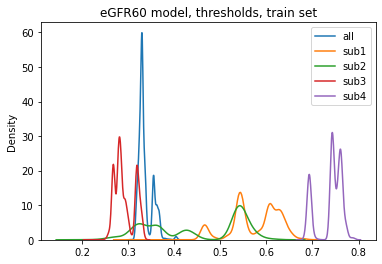

all-1-2-3-4
mean(ci): 0.34 (0.32-0.37), median:0.33
mean(ci): 0.58 (0.47-0.66), median:0.59
mean(ci): 0.45 (0.27-0.57), median:0.44
mean(ci): 0.29 (0.27-0.33), median:0.28
mean(ci): 0.74 (0.69-0.77), median:0.74


In [26]:
# Kernel Density Estimate Plot  
sns.kdeplot(th_box_train_all, label='all')
sns.kdeplot(th_box_train_sub1, label='sub1')
sns.kdeplot(th_box_train_sub2, label='sub2')
sns.kdeplot(th_box_train_sub3, label='sub3')
sns.kdeplot(th_box_train_sub4, label='sub4')

plt.title("eGFR60 model, thresholds, train set")
#plt.xlim(0.8,1)
plt.legend()
plt.show()

print('all-1-2-3-4')
cical(th_box_train_all)
cical(th_box_train_sub1)
cical(th_box_train_sub2)
cical(th_box_train_sub3)
cical(th_box_train_sub4)

## Internal Validation

In [27]:
#testset proteinuria
X_test_features = X_test.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features[std_cols]
X_test_features[std_cols]=scaler.transform(std_df)

In [28]:
# for logistic regression, data
lr = X_test.copy()
lr[['std_age', 'std_uph', 'std_usg']] = X_test_features[std_cols]
#lr.to_csv("/home/danssa/proj_ua/data/df_lr_chasv.v1.csv", encoding='utf-8', index=False)

In [29]:
# dataframe for bootstrap
y_prob = model_new.predict_proba(X_test_features)[:,1]
df_test = X_test.copy()
df_test['prob'] = y_prob

test_all = df_test.copy()
test_sub1 = df_test.query('dm==1')
test_sub2 = df_test.query('htn==1')
test_sub3 = df_test.query('age<65')
test_sub4 = df_test.query('age>=65')

In [30]:
print('test set')
print('total cases, prevalence (cases)')
print('test  all: %d, %.1f (%d)' % (len(test_all), sum(test_all['eGFR_ab'])/len(test_all)*100, sum(test_all['eGFR_ab'])))
print('subgroup1: %d, %.1f (%d)' % (len(test_sub1), sum(test_sub1['eGFR_ab'])/len(test_sub1)*100, sum(test_sub1['eGFR_ab'])))
print('subgroup2: %d, %.1f (%d)' % (len(test_sub2), sum(test_sub2['eGFR_ab'])/len(test_sub2)*100, sum(test_sub2['eGFR_ab'])))
print('subgroup3: %d, %.1f (%d)' % (len(test_sub3), sum(test_sub3['eGFR_ab'])/len(test_sub3)*100, sum(test_sub3['eGFR_ab'])))
print('subgroup4: %d, %.1f (%d)' % (len(test_sub4), sum(test_sub4['eGFR_ab'])/len(test_sub4)*100, sum(test_sub4['eGFR_ab'])))

test set
total cases, prevalence (cases)
test  all: 59180, 3.6 (2142)
subgroup1: 1498, 2.7 (41)
subgroup2: 2313, 1.2 (27)
subgroup3: 55381, 2.7 (1474)
subgroup4: 3799, 17.6 (668)


### test_all

In [31]:
# set dataset and threshold
data = test_all
threshold = mean(th_box_train_all)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_all = []
se_box_all = []
sp_box_all = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])    
        auc_box_all.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred)
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_all.append(se)
        sp_box_all.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [11:38<00:00, 14.32it/s]


In [32]:
print('test_all, bootstrap\nauc-se-sp')
cical(auc_box_all)
cical(se_box_all)
cical(sp_box_all)

test_all, bootstrap
auc-se-sp
mean(ci): 0.89 (0.88-0.90), median:0.89
mean(ci): 0.81 (0.79-0.83), median:0.81
mean(ci): 0.80 (0.80-0.80), median:0.80


### test_sub1, diabetes

In [33]:
# set dataset and threshold
data = test_sub1
threshold = mean(th_box_train_sub1)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub1 = []
se_box_sub1 = []
sp_box_sub1 = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])    
        auc_box_sub1.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred)
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub1.append(se)
        sp_box_sub1.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [00:46<00:00, 215.60it/s]


In [34]:
print('test_sub1, bootstrap\nauc-se-sp')
cical(auc_box_sub1)
cical(se_box_sub1)
cical(sp_box_sub1)

test_sub1, bootstrap
auc-se-sp
mean(ci): 0.88 (0.83-0.93), median:0.88
mean(ci): 0.66 (0.51-0.80), median:0.66
mean(ci): 0.85 (0.83-0.87), median:0.85


### test_sub2, hypertension

In [35]:
# set dataset and threshold
data = test_sub2
threshold = mean(th_box_train_sub2)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub2 = []
se_box_sub2 = []
sp_box_sub2 = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])    
        auc_box_sub2.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred)
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub2.append(se)
        sp_box_sub2.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [00:48<00:00, 205.49it/s]


In [36]:
print('test_sub2, bootstrap\nauc-se-sp')
cical(auc_box_sub2)
cical(se_box_sub2)
cical(sp_box_sub2)

test_sub2, bootstrap
auc-se-sp
mean(ci): 0.85 (0.79-0.91), median:0.85
mean(ci): 0.71 (0.52-0.85), median:0.70
mean(ci): 0.80 (0.79-0.82), median:0.80


### test_sub3, age<65

In [37]:
# set dataset and threshold
data = test_sub3
threshold = mean(th_box_train_sub3)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub3 = []
se_box_sub3 = []
sp_box_sub3 = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])    
        auc_box_sub3.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred)
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub3.append(se)
        sp_box_sub3.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [10:48<00:00, 15.41it/s]


In [38]:
print('test_sub3, bootstrap\nauc-se-sp')
cical(auc_box_sub3)
cical(se_box_sub3)
cical(sp_box_sub3)

test_sub3, bootstrap
auc-se-sp
mean(ci): 0.88 (0.87-0.89), median:0.88
mean(ci): 0.78 (0.76-0.80), median:0.78
mean(ci): 0.81 (0.81-0.82), median:0.81


### test_sub4, age>=65

In [39]:
# set dataset and threshold
data = test_sub4
threshold = mean(th_box_train_sub4)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub4 = []
se_box_sub4 = []
sp_box_sub4 = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])    
        auc_box_sub4.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred)
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub4.append(se)
        sp_box_sub4.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [01:01<00:00, 162.18it/s]


In [40]:
print('test_sub4, bootstrap\nauc-se-sp')
cical(auc_box_sub4)
cical(se_box_sub4)
cical(sp_box_sub4)

test_sub4, bootstrap
auc-se-sp
mean(ci): 0.68 (0.66-0.71), median:0.68
mean(ci): 0.46 (0.42-0.49), median:0.46
mean(ci): 0.80 (0.79-0.82), median:0.80


## External Validation

In [41]:
#external validation in knhanes set

ev_wt = pd.read_csv("/home/danssa/proj_ua/data/knhanes_12y.v1.csv").query('age>=18&age<70')

ev = df_age1[(df_age1['from']=="knhanes") & (df_age1['age']>=18) & (df_age1['age']<80)]
ev['eGFR_ab'] = np.where(ev['eGFR_ckd']<60,1,0)
ev['wt'] = np.array(ev_wt['wt_12y'])

y_test_ev = ev['eGFR_ab']
print("\nev cases=%d, p cases=%d, ratio=%.2f" % (ev.shape[0], sum(y_test_ev), sum(y_test_ev)/ev.shape[0]*100))

X_test_features_ev = ev.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df = X_test_features_ev[std_cols]
X_test_features_ev[std_cols] = scaler.transform(std_df)
print(X_test_features_ev.shape)
X_test_features_ev.describe()


ev cases=54945, p cases=803, ratio=1.46
(54945, 7)


,male,he_usg,he_uph,he_ubld,he_uglu,he_upro,age
count,54945.000000,54945.000000,54945.000000,54945.000000,54945.000000,54945.000000,54945.000000
mean,0.453544,0.067706,-0.570889,0.557139,0.087597,0.113459,0.160051
std,0.497842,0.786572,0.997669,1.019046,0.524088,0.397619,1.104352
min,0.000000,-1.724754,-1.463852,0.000000,0.000000,0.000000,-2.049442
25%,0.000000,-0.472372,-1.463852,0.000000,0.000000,0.000000,-0.699858
50%,0.000000,0.153819,-0.852685,0.000000,0.000000,0.000000,0.173402
75%,1.000000,0.780010,0.369649,1.000000,0.000000,0.000000,1.046663
max,1.000000,1.406201,3.425483,5.000000,5.000000,5.000000,1.999311


In [42]:
# dataframe for bootstrap, external validation set
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
df_test_ev = ev.copy()
df_test_ev['prob'] = y_prob_ev

test_all_ev = df_test_ev.copy()
test_sub1_ev = df_test_ev.query('dm==1')
test_sub2_ev = df_test_ev.query('htn==1')
test_sub3_ev = df_test_ev.query('age<65')
test_sub4_ev = df_test_ev.query('age>=65')

In [43]:
print('external validation set, knhanes')
print('total cases, prevalence (cases)')
print('all      : %d, %.1f (%d)' % (sum(test_all_ev['wt']), sum(test_all_ev.query('eGFR_ab==1')['wt'])/sum(test_all_ev['wt'])*100, sum(test_all_ev.query('eGFR_ab==1')['wt'])))
print('subgroup1: %d, %.1f (%d)' % (sum(test_sub1_ev['wt']), sum(test_sub1_ev.query('eGFR_ab==1')['wt'])/sum(test_sub1_ev['wt'])*100, sum(test_sub1_ev.query('eGFR_ab==1')['wt'])))
print('subgroup2: %d, %.1f (%d)' % (sum(test_sub2_ev['wt']), sum(test_sub2_ev.query('eGFR_ab==1')['wt'])/sum(test_sub2_ev['wt'])*100, sum(test_sub2_ev.query('eGFR_ab==1')['wt'])))
print('subgroup3: %d, %.1f (%d)' % (sum(test_sub3_ev['wt']), sum(test_sub3_ev.query('eGFR_ab==1')['wt'])/sum(test_sub3_ev['wt'])*100, sum(test_sub3_ev.query('eGFR_ab==1')['wt'])))
print('subgroup4: %d, %.1f (%d)' % (sum(test_sub4_ev['wt']), sum(test_sub4_ev.query('eGFR_ab==1')['wt'])/sum(test_sub4_ev['wt'])*100, sum(test_sub4_ev.query('eGFR_ab==1')['wt'])))

external validation set, knhanes
total cases, prevalence (cases)
all      : 32808984, 1.0 (341722)
subgroup1: 2390898, 5.1 (122148)
subgroup2: 6905491, 3.2 (223174)
subgroup3: 30970242, 0.7 (217567)
subgroup4: 1838742, 6.8 (124154)


### test_all_ev

In [44]:
# set dataset and threshold
data = test_all_ev
threshold = mean(th_box_train_all)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_all_ev = []
se_box_all_ev = []
sp_box_all_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])    
        auc_box_all_ev.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred, sample_weight=boot['wt'])
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_all_ev.append(se)
        sp_box_all_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [10:48<00:00, 15.43it/s]


In [45]:
print('test_all_ev, bootstrap\nauc-se-sp')
cical(auc_box_all_ev)
cical(se_box_all_ev)
cical(sp_box_all_ev)

test_all_ev, bootstrap
auc-se-sp
mean(ci): 0.90 (0.89-0.92), median:0.90
mean(ci): 0.86 (0.83-0.89), median:0.86
mean(ci): 0.77 (0.77-0.78), median:0.77


### test_sub1_ev, diabetes

In [46]:
# set dataset and threshold
data = test_sub1_ev
threshold = mean(th_box_train_sub1)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub1_ev = []
se_box_sub1_ev = []
sp_box_sub1_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])    
        auc_box_sub1_ev.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred, sample_weight=boot['wt'])
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub1_ev.append(se)
        sp_box_sub1_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [01:12<00:00, 138.60it/s]


In [47]:
print('test_sub1_ev, bootstrap\nauc-se-sp')
cical(auc_box_sub1_ev)
cical(se_box_sub1_ev)
cical(sp_box_sub1_ev)

test_sub1_ev, bootstrap
auc-se-sp
mean(ci): 0.79 (0.76-0.82), median:0.79
mean(ci): 0.67 (0.60-0.73), median:0.67
mean(ci): 0.75 (0.74-0.76), median:0.75


### test_sub2_ev, hypertension

In [48]:
# set dataset and threshold
data = test_sub2_ev
threshold = mean(th_box_train_sub2)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub2_ev = []
se_box_sub2_ev = []
sp_box_sub2_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])    
        auc_box_sub2_ev.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred, sample_weight=boot['wt'])
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub2_ev.append(se)
        sp_box_sub2_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [02:43<00:00, 61.21it/s]


In [49]:
print('test_sub2_ev, bootstrap\nauc-se-sp')
cical(auc_box_sub2_ev)
cical(se_box_sub2_ev)
cical(sp_box_sub2_ev)

test_sub2_ev, bootstrap
auc-se-sp
mean(ci): 0.83 (0.81-0.85), median:0.83
mean(ci): 0.81 (0.76-0.85), median:0.81
mean(ci): 0.68 (0.67-0.69), median:0.68


### test_sub3_ev, age<65

In [50]:
# set dataset and threshold
data = test_sub3_ev
threshold = mean(th_box_train_sub3)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub3_ev = []
se_box_sub3_ev = []
sp_box_sub3_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])    
        auc_box_sub3_ev.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred, sample_weight=boot['wt'])
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub3_ev.append(se)
        sp_box_sub3_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [09:45<00:00, 17.09it/s]


In [51]:
print('test_sub3_ev, bootstrap\nauc-se-sp')
cical(auc_box_sub3_ev)
cical(se_box_sub3_ev)
cical(sp_box_sub3_ev)

test_sub3_ev, bootstrap
auc-se-sp
mean(ci): 0.90 (0.88-0.91), median:0.90
mean(ci): 0.83 (0.78-0.87), median:0.83
mean(ci): 0.77 (0.76-0.77), median:0.77


### test_sub4_ev, age>=65

In [52]:
# set dataset and threshold
data = test_sub4_ev
threshold = mean(th_box_train_sub4)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub4_ev = []
se_box_sub4_ev = []
sp_box_sub4_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])    
        auc_box_sub4_ev.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred, sample_weight=boot['wt'])
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub4_ev.append(se)
        sp_box_sub4_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [01:19<00:00, 125.98it/s]


In [53]:
print('test_sub4_ev, bootstrap\nauc-se-sp')
cical(auc_box_sub4_ev)
cical(se_box_sub4_ev)
cical(sp_box_sub4_ev)

test_sub4_ev, bootstrap
auc-se-sp
mean(ci): 0.63 (0.60-0.67), median:0.63
mean(ci): 0.51 (0.45-0.57), median:0.51
mean(ci): 0.66 (0.65-0.68), median:0.66


## ROC curve, internal and external set

In [54]:
#function of finding the index nearest train mean threshold
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

### internal, all

eGFR60 model

Classification Report

Best Threshold=0.296, sensitivity = 0.85, specificity = 0.77, J=0.619
              precision    recall  f1-score   support

      normal       0.99      0.77      0.87     57038
    abnormal       0.12      0.85      0.21      2142

    accuracy                           0.77     59180
   macro avg       0.56      0.81      0.54     59180
weighted avg       0.96      0.77      0.84     59180



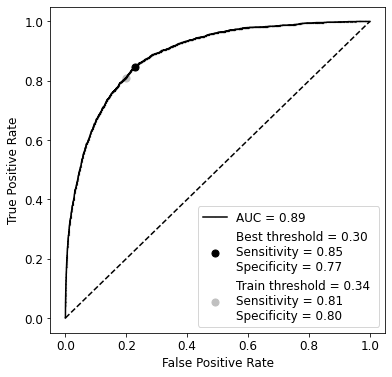

In [55]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = df_test['prob']
y_test = df_test['eGFR_ab']
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
# obtain the nearest train best threshold
n_th_test_all, idx = find_nearest(thresholds, mean(th_box_train_all))

print('eGFR60 model')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (y_prob > best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
n_sens, n_spec = tpr[idx], 1-fpr[idx]

# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 12
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(fpr[ix], tpr[ix], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh, sens, spec))
plt.scatter(fpr[idx], tpr[idx], marker='o', s=50, color='silver', 
            label='Train threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (n_th_test_all, n_sens, n_spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

### external, all

eGFR60 model, knhanes, external validation

Classification Report

Best Threshold=0.407, sensitivity = 0.82, specificity = 0.83, J=0.656
              precision    recall  f1-score   support

      normal       1.00      0.84      0.91 32467262.433003858
    abnormal       0.05      0.82      0.09 341722.349350576

    accuracy                           0.83 32808984.782354433
   macro avg       0.52      0.83      0.50 32808984.782354433
weighted avg       0.99      0.83      0.90 32808984.782354433



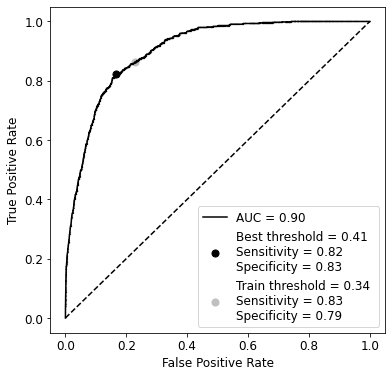

In [56]:
# external validation 

# Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob_ev = df_test_ev['prob']
# calculate roc curves
fpr_ev, tpr_ev, thresholds_ev = roc_curve(y_test_ev, y_prob_ev, sample_weight=ev['wt'])
# get the best threshold
J_ev = tpr_ev - fpr_ev
ix_ev = argmax(J_ev)
best_thresh_ev = thresholds_ev[ix_ev]
# obtain the nearest train best threshold
n_th_test_all_ev, idx_ev = find_nearest(thresholds_ev, mean(th_box_train_all))

print('eGFR60 model, knhanes, external validation')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh_ev, tpr_ev[ix_ev], 1-fpr_ev[ix_ev], J_ev[ix_ev]))

y_prob_pred_ev = (y_prob_ev > best_thresh_ev).astype(bool)
print(classification_report(y_test_ev, y_prob_pred_ev, target_names=['normal', 'abnormal'], sample_weight=ev['wt']))

#plot roc and best threshold
sens_ev, spec_ev = tpr_ev[ix_ev], 1-fpr_ev[ix_ev]
n_sens_ev, n_spec_ev = tpr[idx_ev], 1-fpr[idx_ev]

# plot the roc curve for the model
#plt.rcParams["figure.figsize"] = (10,10)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr_ev, tpr_ev, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(fpr_ev[ix_ev], tpr_ev[ix_ev], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh_ev, sens_ev, spec_ev))
plt.scatter(fpr_ev[idx_ev], tpr_ev[idx_ev], marker='o', s=50, color='silver', 
            label='Train threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (n_th_test_all_ev, n_sens_ev, n_spec_ev))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

### both internal and external

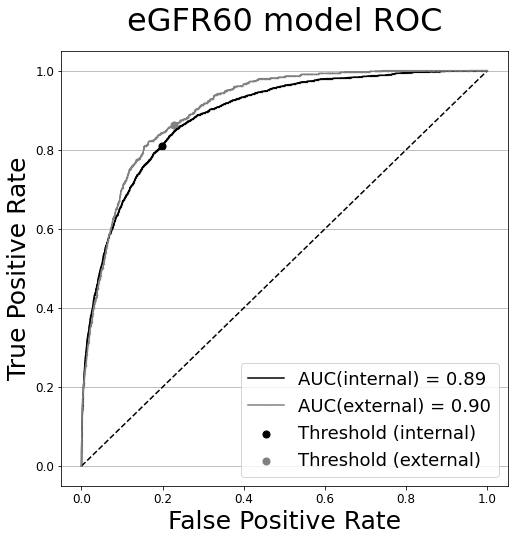

In [57]:
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (8,8)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')

plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC(internal) = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(1-mean(sp_box_all), mean(se_box_all), marker='o', s=50, color='k'
            , label='Threshold (internal)' 
            #% (best_thresh)
           )

plt.plot(fpr_ev, tpr_ev, marker='.', color='grey', markersize=0.05, label="AUC(external) = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(1-mean(sp_box_all_ev), mean(se_box_all_ev), marker='o', s=50, color='grey'
            , label='Threshold (external)' 
            #% (best_thresh_ev)
           )

# axis labels
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
plt.legend(loc=4, fontsize=18)
plt.title('eGFR60 model ROC', size=32, pad=20)
# show the plot
#plt.show()

plt.grid(axis='y')
#plt.ylim(1.0)
# save as png
#plt.savefig('/home/danssa/proj_ua/images/5sub/60model_roc.png', dpi=300)

### sub4, age>=65

eGFR60 model

Classification Report

Best Threshold=0.708, sensitivity = 0.54, specificity = 0.74, J=0.280
              precision    recall  f1-score   support

      normal       0.88      0.74      0.80      3131
    abnormal       0.30      0.54      0.39       668

    accuracy                           0.70      3799
   macro avg       0.59      0.64      0.60      3799
weighted avg       0.78      0.70      0.73      3799



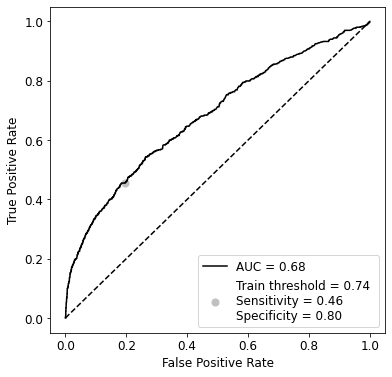

In [58]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = test_sub4['prob']
y_test = test_sub4['eGFR_ab']
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
# obtain the nearest train best threshold
n_th_test_sub4, idx = find_nearest(thresholds, mean(th_box_train_sub4))

print('eGFR60 model')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (y_prob > best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
n_sens, n_spec = tpr[idx], 1-fpr[idx]

# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 12
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test, y_prob))
#plt.scatter(fpr[ix], tpr[ix], marker='o', s=50, color='k', 
#            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh, sens, spec))
plt.scatter(fpr[idx], tpr[idx], marker='o', s=50, color='silver', 
            label='Train threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (n_th_test_sub4, n_sens, n_spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()